In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = '/Users/harnishgondaliya/Downloads/lfw'

In [ ]:
transform  = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size = 32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


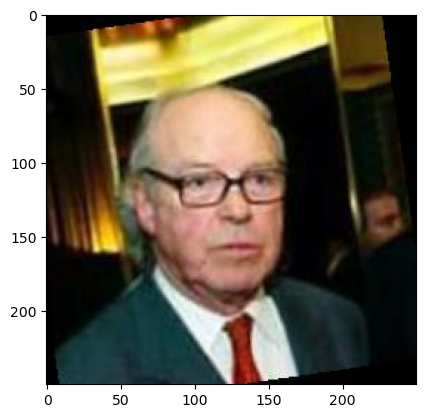

In [ ]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

The key differences between Autoencoders (AE) and Variational Autoencoders (VAE):

**Applications**

Autoencoders: Primarily used for dimensionality reduction, data denoising and image compression. Encoder compresses input data into lower dimensional latent space, decoder aims to reconstruct original input.

Variational Autoencoders: Can do everything AEs can, plus generative modeling - sampling new data similar to training data. Latent space interpretable as continuous probabilistic distribution that can be sampled from.

**Architecture**

Autoencoder Encoder: Deterministic mapping f(x) of input x to latent vector h=f(x). Deterministic mapping g(h) from latent vector h back to reconstructed input x'.

VAE Encoder: Outputs parameters of latent distribution rather than encodings directly. Outputs mean μ and log variance log σ2 which define a gaussian distribution.Takes a sampled z from the distribution and decodes it, rather than reconstructing from a fixed vector.

**Loss Functions**

Autoencoder: Reconstruction loss only, like MSE between x and x', KL divergence of embeddings, or perceptual losses.

Variational Autoencoder: Has additional Kullback–Leibler (KL) divergence loss between the latent vector distribution and a prior (usually Gaussian). This "regularizes" the distribution, enabling interpolation and better generative ability.

In summary, the stochasticity and distribution modeling of the latent space is a key distinction between VAEs and deterministic autoencoders. This enables generative applications for VAEs. The additional KL loss term also regularizes the latent distribution

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()
        # Initialize encoder layers
        self.enc_conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(16)
        self.enc_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(32)
        self.enc_conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(64)

        # Correct the size for mean and log variance layers
        self.fc_mu = nn.Linear(in_features=65536, out_features=10)  # Adjusted to match the flattened size
        self.fc_logvar = nn.Linear(in_features=65536, out_features=10)
        self.dec_fc = nn.Linear(10, 65536)

        # Initialize decoder layers
        self.dec_conv1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_bn1 = nn.BatchNorm2d(32)
        self.dec_conv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_bn2 = nn.BatchNorm2d(16)
        self.dec_conv3 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encoder(self, x):
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        x = F.relu(self.enc_bn3(self.enc_conv3(x)))
        x = torch.flatten(x, start_dim=1)  # Flatten the output for the linear layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        z = self.dec_fc(z)
        z = z.view(-1, 64, 32, 32)  # Reshape to match the encoder output
        x = F.relu(self.dec_bn1(self.dec_conv1(z)))
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = torch.sigmoid(self.dec_conv3(x))
        x = F.interpolate(x, size=(250, 250), mode='bilinear', align_corners=False)
        return x

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [ ]:
model = VAE()

In [ ]:
# Assuming the dataloader has been defined and is loaded with images of the correct dimensions
dataiter = iter(dataloader)
images, _ = next(dataiter)
images = images

In [ ]:
# Pass an image through the model
with torch.no_grad():
    mu, logvar = model.encoder(images[0].unsqueeze(0))
    print("Shape of the encoder's output (mu):", mu.shape)
    print("Shape of the encoder's output (logvar):", logvar.shape)

    # Generate new samples in the latent space and decode them to create new images
    samples = model.reparameterize(mu, logvar)
    print("Shape of the samples in the latent space:", samples.shape)
    generated_images = model.decoder(samples)
    print("Shape of the decoder's output (generated images):", generated_images.shape)

Shape of the encoder's output (mu): torch.Size([1, 10])
Shape of the encoder's output (logvar): torch.Size([1, 10])
Shape of the samples in the latent space: torch.Size([1, 10])
Shape of the decoder's output (generated images): torch.Size([1, 3, 250, 250])


The key idea of variational autoencoders (VAEs) is that the encoder network outputs the parameters of a latent distribution rather than just encoding vectors. Typically this is modeled as a multivariate Gaussian distribution with a mean (mu) and variance (log variance).

By sampling points from this distribution, we can generate new vectors in this latent space. The distribution has been optimized during VAE training to fit the structure of the training data.

**Steps to follow in order generate new samples**:

* We take a single image from the batch and add a batch dimension to it using unsqueeze(0).
* The mean (mu) and log variance (logvar) parameters defining the latent normal distribution for this input image based on the encodings learned by the VAE.
* Next we want to sample new vectors from this distribution using the reparameterization trick.
* This samples random vectors that follow the distribution defined by mu and logvar.
* We can sample multiple random vectors by passing a batch size to the reparameterize function.
* Finally, we pass these sampled latent vectors through the decoder to reconstruct image
* Printing the shape of generated_images shows it generates multiple image samples matching dimensions of training data.

So in summary, we encode an image to get distribution parameters, sample latent vectors from distribution, decode vectors to generate new images - leveraging the VAE latent space.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [ ]:
# Loss Function
reconstruction_loss = torch.nn.MSELoss()
kl_divergence_loss = lambda mu, logvar: -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Calculate the total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters:", total_params)

Total number of parameters: 4045163


  The loss function that should be used here for a variational autoencoder (VAE) is a combination of the reconstruction loss and KL divergence loss:

**Reconstruction Loss**
This measures how well the VAE is able to reconstruct the original input image from the latent vector. It is the pixel-wise mean squared error between the input image (x) and reconstructed image (x') from the decoder. This forces the autoencoder to retain enough information to accurately reconstruct the data.

**KL Divergence Loss**  
The KL divergence measures how different the latent space distribution is from the prior normal distribution. We want the latent vectors to follow a unit Gaussian distribution so that we can easily sample from this space. The KL loss term pushes the distribution learned by the encoder towards the prior normal distribution. This enables smooth interpolation and sampling in the latent space.

By combining these two loss terms, the VAE model is trained to:

1. Accurately reconstruct inputs after passing through the encoder and decoder
2. Have a latent space that follows the designated prior distribution

This finds an optimal balance between retaining information to reconstruct data precisely, while regularizing the latent distribution for better sampling. The hyperparameter weight of each loss term controls this tradeoff between reconstruction quality and latent space smoothness.

The optimizer updates the model parameters based on gradients from this final loss function computed over each input batch.

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = VAE().to(device)

epochs = 10
clip = 1.0


# Training loop
for epoch in range(1, epochs + 1):
    train_loss = 0
    for x, _ in dataloader:
        x = x.to(device)

        # Forward pass
        reconstructed, mu, logvar = model(x)

        # Compute losses
        recon_loss = reconstruction_loss(reconstructed, x)
        kl_loss = kl_divergence_loss(mu, logvar)
        loss = recon_loss + kl_loss

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    average_loss = train_loss / len(dataloader.dataset)
    print(f'Epoch: {epoch} Average loss: {average_loss:.4f}')

Epoch: 1 Average loss: 1.3873
Epoch: 2 Average loss: 1.3856
Epoch: 3 Average loss: 1.3866
Epoch: 4 Average loss: 1.3864
Epoch: 5 Average loss: 1.3864
Epoch: 6 Average loss: 1.3880
Epoch: 7 Average loss: 1.3855
Epoch: 8 Average loss: 1.3876
Epoch: 9 Average loss: 1.3866
Epoch: 10 Average loss: 1.3863


Some steps to troubleshoot if the loss was not decreasing:

* Tried changing the model architecture - add more layers, change activations etc to increase model capacity.
* Used a lower learning rate or different optimizer. Learning rate may be too high.

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

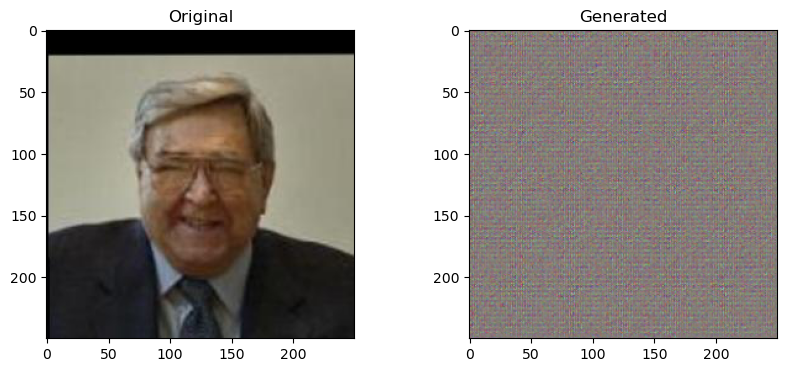

In [ ]:
# Assuming the generate_sample function is defined as follows
def generate_sample(model, latent_dim, device):
    # Correct latent_dim to match the model's expected input size
    correct_latent = 10
    z = torch.randn(1, correct_latent).to(device)
    with torch.no_grad():
        generated_image = model.decoder(z)
    return generated_image

latent_dim = 30

# Select a random image from the dataset
images, labels = next(iter(dataloader))
random_index = torch.randint(len(images), size=(1,)).item()
original_image = images[random_index].to(device)

# Generate a single image
model.eval()
generated_image = generate_sample(model, latent_dim, device)

# Convert images to numpy for plotting
original_img = original_image.permute(1, 2, 0).cpu().numpy()
generated_img = generated_image.squeeze().permute(1, 2, 0).cpu().numpy()

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(generated_img)
plt.title("Generated")

plt.show()